In [1]:

# load a low-rank RNN
import sys
sys.path.append('../')

from low_rank_rnns.test_modules_vanilla import *

from low_rank_rnns import TF, stats, plotting as plot, helpers, rankone, ranktwo, clustering

from matplotlib import pyplot as plt
# %matplotlib notebook

size = 100
noise_std = 1e-2
alpha = .1
lr = 1e-3
rank = 15

# # load model
x_train, y_train, mask_train, cohAll_train, x_val, y_val, mask_val, cohAll_val = TF.generate_checker_data(5000)

net_lo = LowRankRNN(3, size, 1, noise_std, alpha, rank=rank)
net_lo.load_state_dict(torch.load(f'../models/TFnew_rank{rank}.pt', map_location='cpu'))


loss, acc, out, decisions, target_decisions, traj = TF.test_checker(net_lo, x_val, y_val, mask_val)
print(f'loss={loss:.3f}, acc={acc:.3f}')



loss=0.195, acc=0.998


# Plot psth

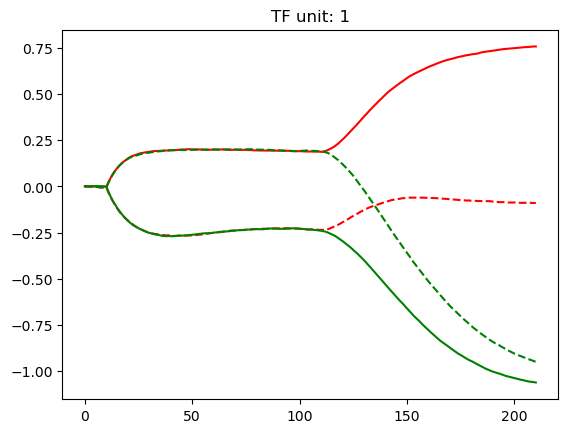

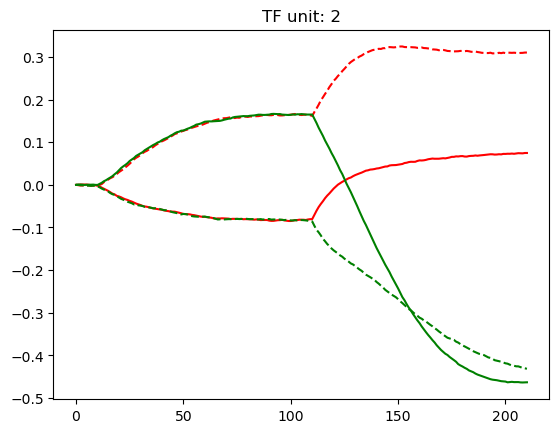

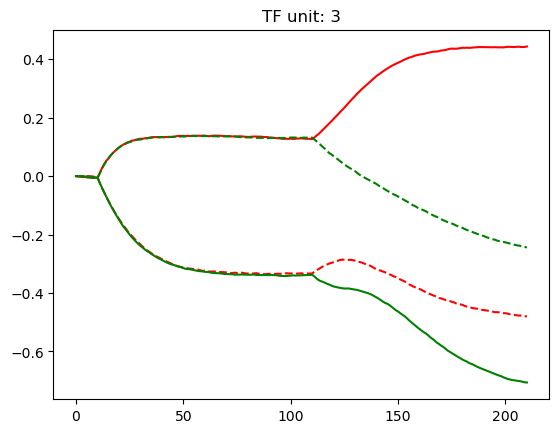

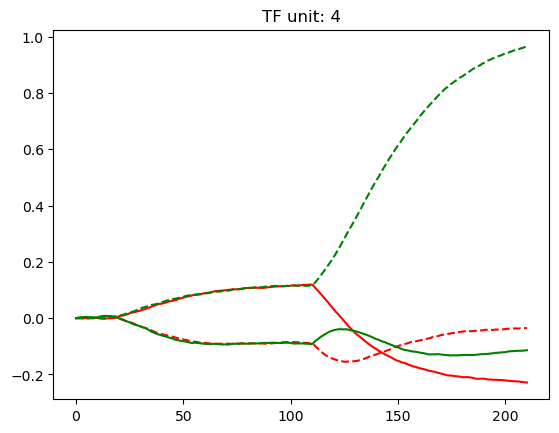

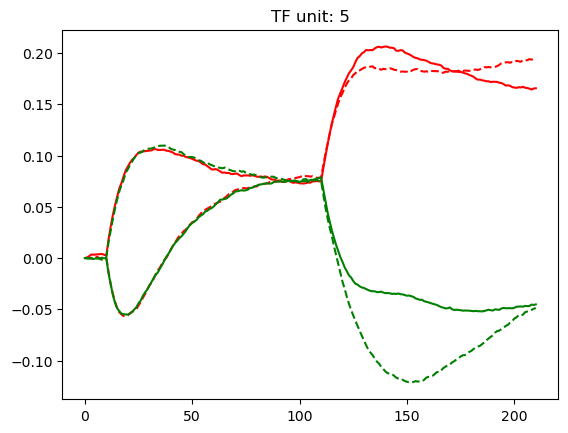

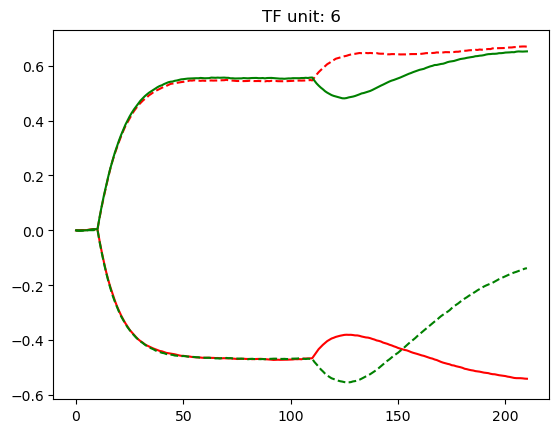

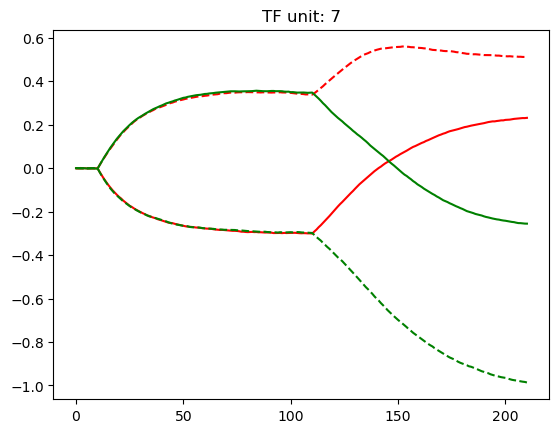

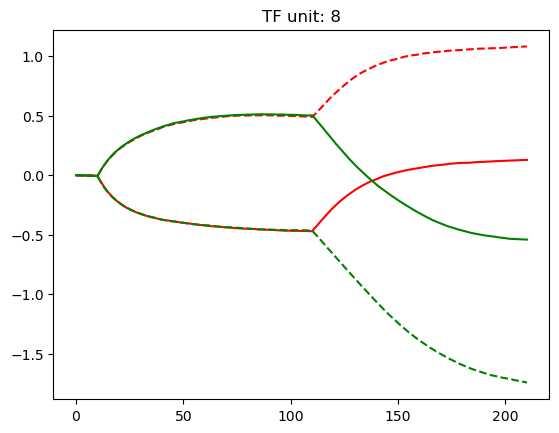

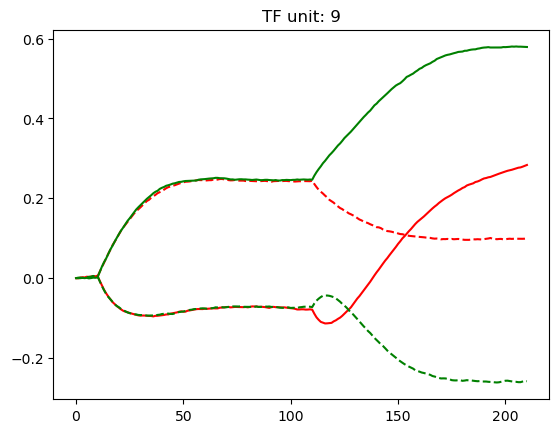

In [2]:


traj = traj.cpu()
decisions = decisions.cpu()

traj1 = traj.detach().numpy()

# traj1 = np.maximum(traj1, 0)

decisions1 = decisions.detach().numpy()

tfRL = traj1[np.logical_and(decisions1 == -1, cohAll_val > 0),:,:]
tfRR = traj1[np.logical_and(decisions1 == 1, cohAll_val > 0),:,:]
tfGL = traj1[np.logical_and(decisions1 == -1, cohAll_val < 0),:,:]
tfGR = traj1[np.logical_and(decisions1 == 1, cohAll_val < 0),:,:]

for n in range(1,10):
    plt.figure()
    plt.plot(np.mean(tfRL,axis = 0)[:,n], 'r-')
    plt.plot(np.mean(tfRR,axis = 0)[:,n], 'r--')
    plt.plot(np.mean(tfGL,axis = 0)[:,n], 'g-')
    plt.plot(np.mean(tfGR,axis = 0)[:,n], 'g--')
    plt.title("TF unit: " + str(n))

In [3]:
# umap 

import umap

a = np.mean(tfRL,axis = 0)
b = np.mean(tfRR,axis = 0)
c = np.mean(tfGL,axis = 0)
d = np.mean(tfGR,axis = 0)

psth = np.concatenate((a,b,c,d), axis=0) # error!

psth.shape

(844, 100)

/home/tianwang/anaconda3/envs/pyt/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


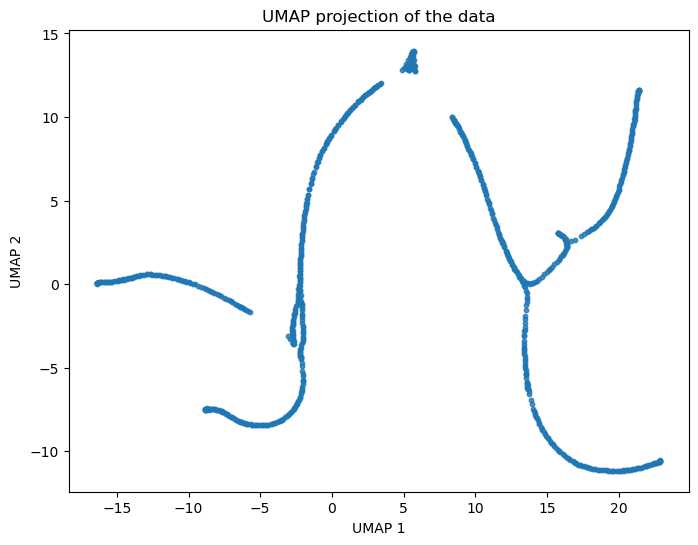

In [4]:
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
embedding = reducer.fit_transform(psth)  # shape will be (844, 2)

# Step 2: Plot the result
plt.figure(figsize=(8, 6))
plt.scatter(embedding[:, 0], embedding[:, 1], s=10, alpha=0.8)
plt.title("UMAP projection of the data")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()



/home/tianwang/anaconda3/envs/pyt/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


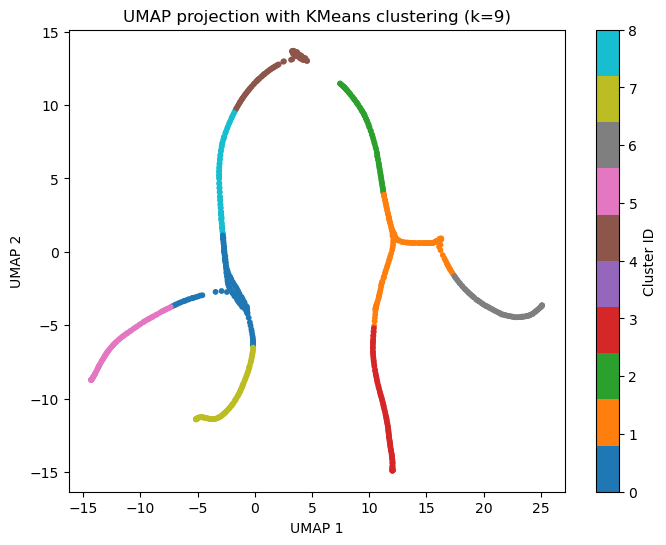

In [17]:
import numpy as np
import umap
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Step 1: UMAP dimensionality reduction
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
embedding = reducer.fit_transform(psth)  # data: (844, 100)

# Step 2: Try different K for KMeans and pick best using silhouette score
scores = []
range_k = range(2, 10)
for k in range_k:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(embedding)
    score = silhouette_score(embedding, labels)
    scores.append(score)

# Step 3: Choose best K
best_k = range_k[np.argmax(scores)]
kmeans = KMeans(n_clusters=best_k, random_state=42)
cluster_labels = kmeans.fit_predict(embedding)

# Step 4: Plot UMAP with cluster coloring
plt.figure(figsize=(8, 6))
plt.scatter(embedding[:, 0], embedding[:, 1], c=cluster_labels, cmap='tab10', s=10)
plt.title(f"UMAP projection with KMeans clustering (k={best_k})")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.colorbar(label='Cluster ID')
plt.show()

# full-tank vs low-rank

In [25]:

net_lo.cpu().svd_reparametrization()

# n: low-rank Wrec connectivity vector n
n = net_lo.n.cpu().detach().numpy()


# m: low-rank Wrec connectivity vector m
m = net_lo.m.cpu().detach().numpy()


In [4]:
trajLow = np.zeros((4, tfRL.shape[1], tfRL.shape[2]))
trajLow[0,:,:] = np.mean(tfRL,axis = 0)
trajLow[1,:,:] =np.mean(tfRR,axis = 0)
trajLow[2,:,:] =np.mean(tfGL,axis = 0)
trajLow[3,:,:] =np.mean(tfGR,axis = 0)

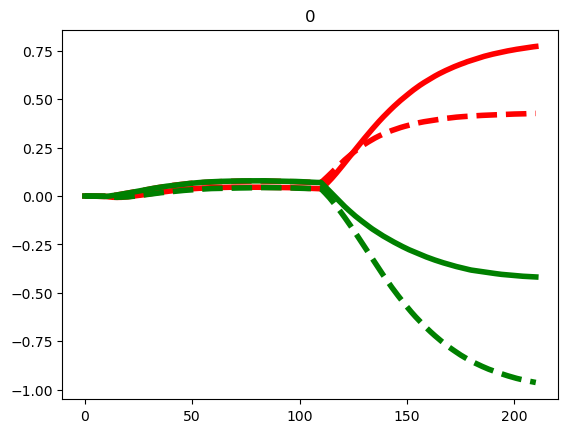

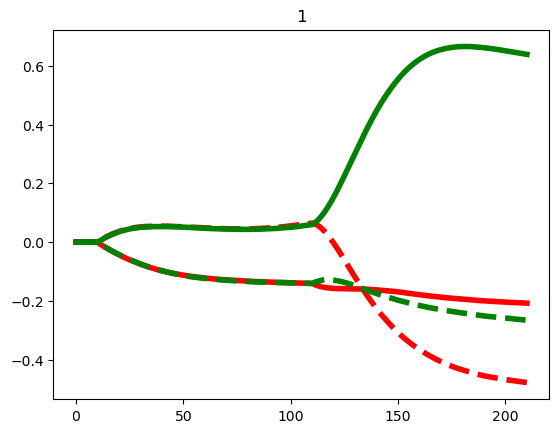

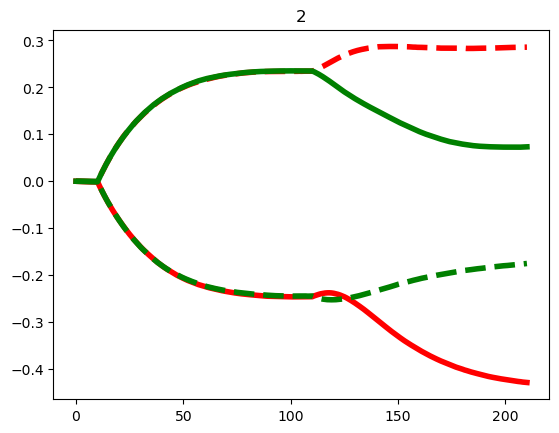

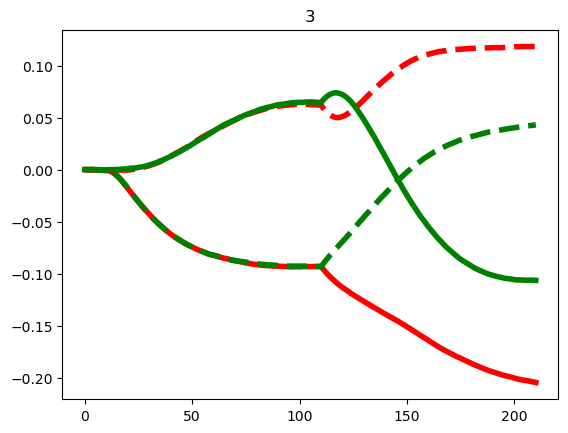

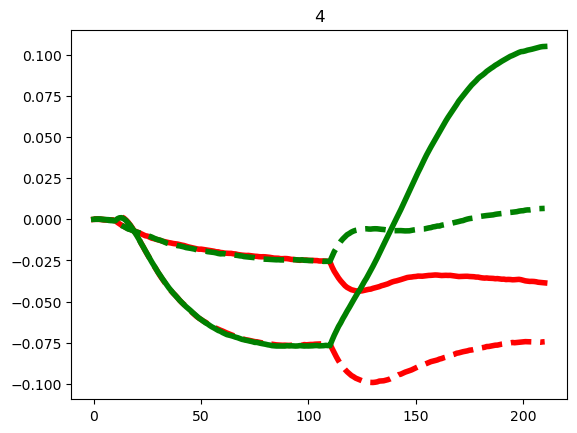

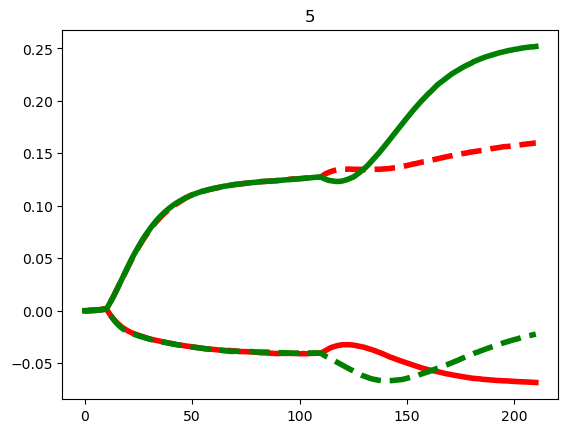

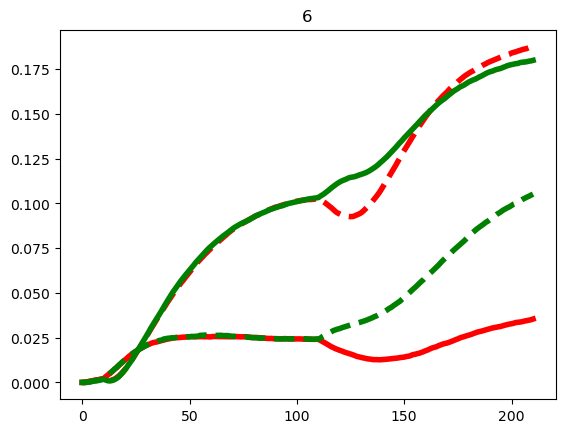

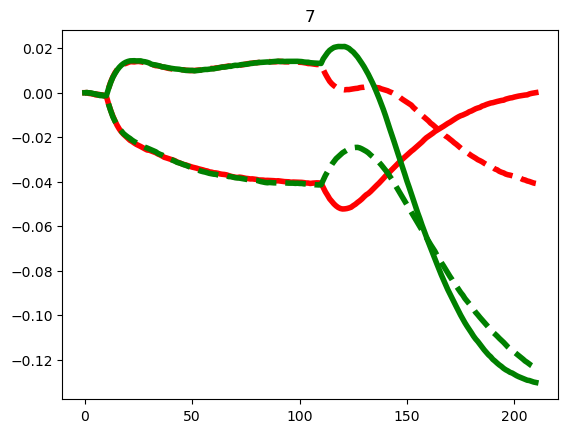

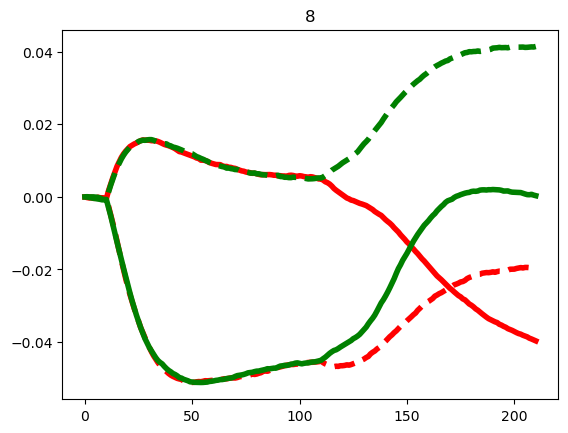

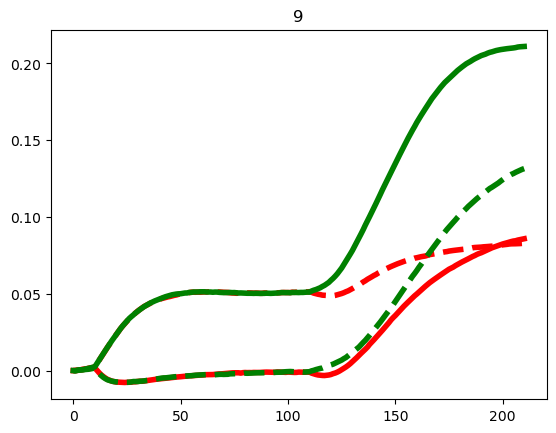

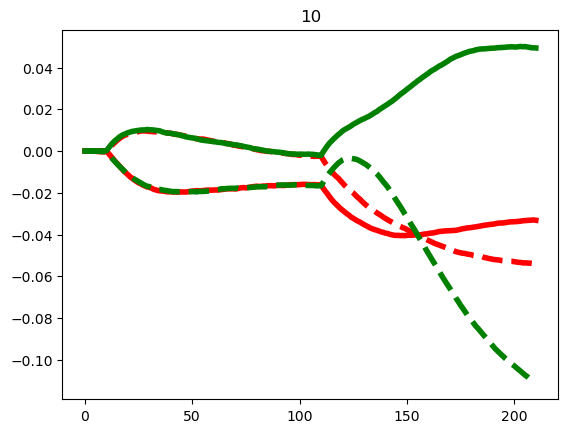

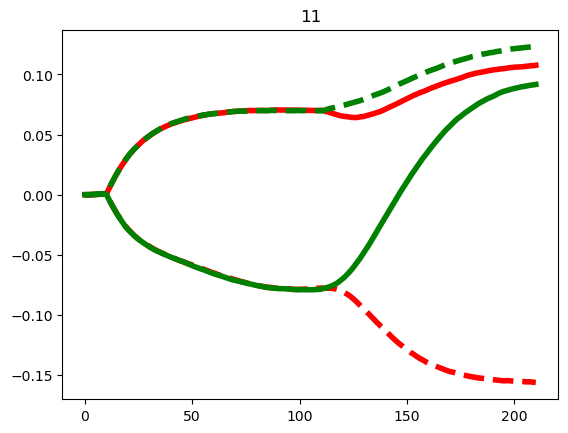

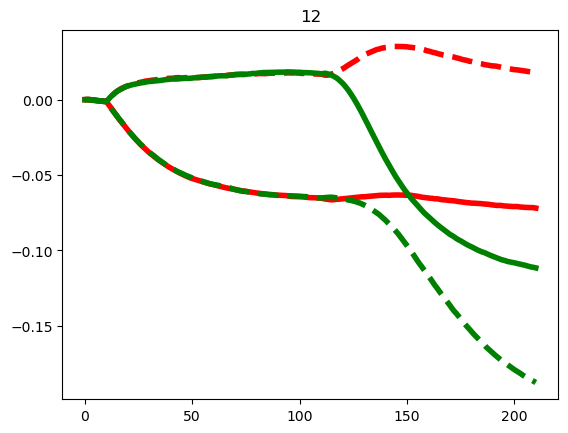

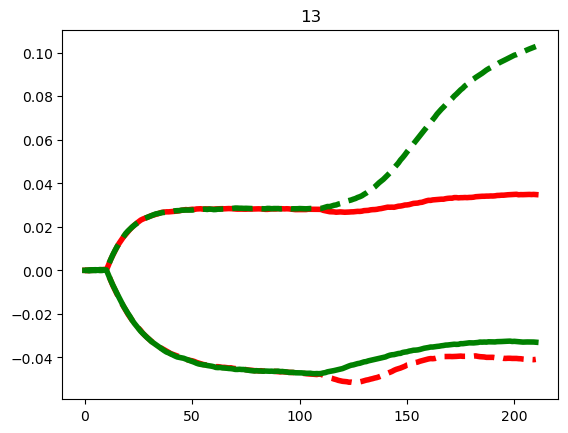

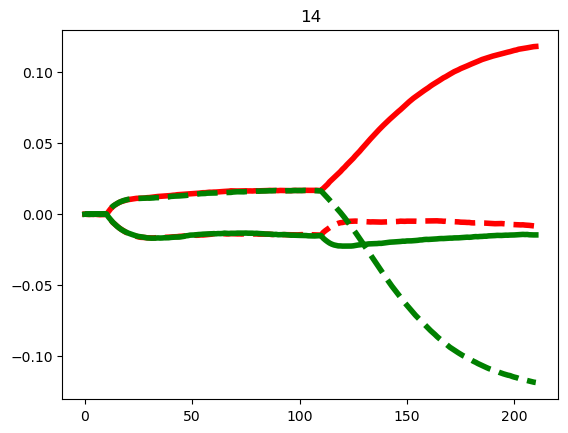

In [27]:
colors = ['red', 'red', 'green', 'green']
lineStyle = ['-', '--', '-', '--']


def projLow(trajLow, m, plotTraj): 
    # project low rank rnn traj on m vector
    kap = np.zeros((trajLow.shape[0], trajLow.shape[1], m.shape[1]))
    for ii in range(m.shape[1]):
        kap[:,:,ii] = trajLow @ m[:,ii] / size
    
    
    colors = ['red', 'red', 'green', 'green']
    lineStyle = ['-', '--', '-', '--']

    if plotTraj:
        for jj in range(kap.shape[2]):
            plt.figure()
            for i in range(4):
                plt.plot(kap[i,:,jj], c=colors[i], lw=4, ls=lineStyle[i])
            plt.title(jj)
            plt.show()

    return kap



kap = projLow(trajLow, m, True)




In [ ]:


# low rank RNN PCA 

def areaPCA(trajLow):


    TOn = 10
    COn = 100
    
    pca = plot.pca_cumvar(trajLow, n_components=10)
    plt.ylim(0, 1.02)
    plt.axhline(1, ls='--', c='gray')
    plt.show()
    
    labels = ['RL', 'RR', 'GL', 'GR']
    
    ax1 = pca.components_[0]
    ax2 = pca.components_[1]
    ax3 = pca.components_[2]
    ax4 = pca.components_[3]
    
    k1 = trajLow @ ax1
    k2 = trajLow @ ax2
    k3 = trajLow @ ax3
    k4 = trajLow @ ax4

    colors = ['red', 'red', 'green', 'green']
    lineStyle = ['-', '--', '-', '--']

    
    plt.figure()
    for i in range(4):
    #      plt.plot(kap1[i], kap2[i], c=colors[i], lw=4, ls = lineStyle[i])
        plt.plot(k1[i], c=colors[i], lw=4, ls=lineStyle[i])
    plt.show()
    
    plt.figure()
    for i in range(4):
    #      plt.plot(kap1[i], kap2[i], c=colors[i], lw=4, ls = lineStyle[i])
        plt.plot(k2[i],c=colors[i], lw=4, ls=lineStyle[i])
    plt.show()
    
    plt.figure()
    for i in range(4):
        plt.plot(k3[i],c=colors[i], lw=4, ls =lineStyle[i], label=labels[i])
    plt.show()
    
    plt.figure()
    for i in range(4):
        plt.plot(k4[i], c=colors[i], lw=4, ls = lineStyle[i], label=labels[i])
    plt.show()
    
    # # 3D pca plot
    # from mpl_toolkits.mplot3d import Axes3D
    # fig = plt.figure()
    # ax = fig.add_subplot(111, projection='3d')

    # for i in range(4):
    #     plt.plot(k1[i], k2[i], k3[i], c=colors[i], lw=4, ls = lineStyle[i])
    #     ax.scatter(k1[i, TOn], k2[i, TOn], k3[i, TOn], c='black',
    #             marker='.', s=400)
    #     ax.scatter(k1[i, COn], k2[i, COn], k3[i, COn], c= 'magenta',
    #             marker='.', s=400)
    # ax.axis('equal')


areaPCA(trajLow)


In [4]:
a = np.mean(tfRL,axis = 0)
b = np.mean(tfRR,axis = 0)
c = np.mean(tfGL,axis = 0)
d = np.mean(tfGR,axis = 0)

psth = np.concatenate((a,b,c,d), axis=0) # error!


In [ ]:
import numpy as np
from sklearn.decomposition import PCA

# Assuming psth is already defined as a NumPy array of shape (844, 100)

# Step 1: Center the data (optional but recommended)
# psth_centered = psth - np.mean(psth, axis=0)

# Step 2: Run PCA
pca = PCA()
pca.fit(psth)

# Step 3: Access results
explained_variance = pca.explained_variance_ratio_  # Fraction of variance explained by each PC
components = pca.components_                        # Principal axes in feature space
scores = pca.transform(psth_centered)               # Projection of data onto PC space


# fields

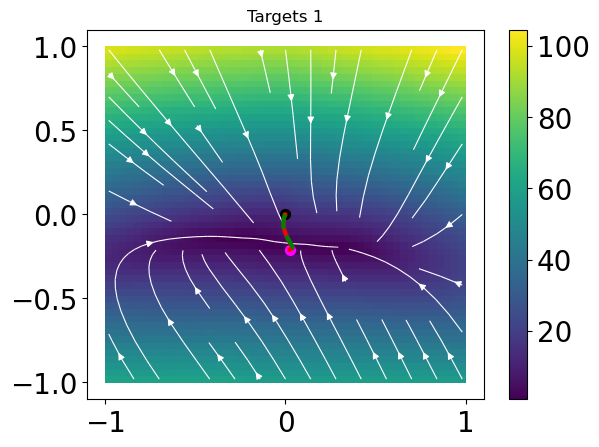

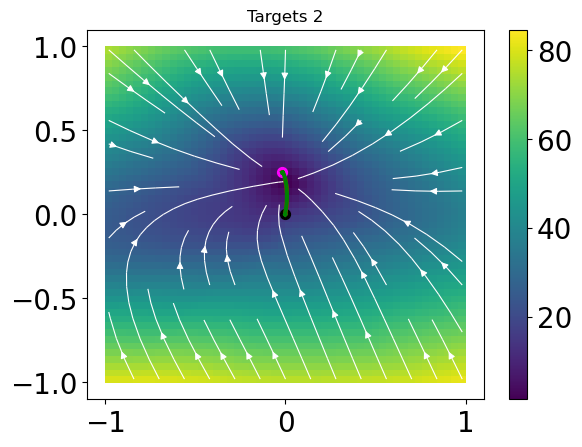

In [44]:
TOn = 10
COn = 100

# only target epoch
dim1 = 0
dim2 = 2
kap1T = kap[:,:COn, dim1]
kap2T = kap[:,:COn, dim2]
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
[ax, mappable] = ranktwo.plot_field(net_lo, m[:, dim1], m[:,dim2], -1, 1, -1, 1, input=torch.tensor([0.,1, -1]))
mappable.set_cmap('viridis')
plt.colorbar(mappable)


plt.plot(kap1T[0], kap2T[0], c=colors[0], lw=3, ls=lineStyle[0])
plt.plot(kap1T[3], kap2T[3], c=colors[3], lw=3, ls=lineStyle[3])
plt.scatter(kap[0, TOn,dim1], kap[0, TOn, dim2], c= 'k',
    marker='.', s=200)  
plt.scatter(kap[0, COn, dim1], kap[0, COn, dim2], c= 'magenta',
    marker='.', s=200) 
        
plt.title('Targets 1')        
# # plt.savefig('TFT1.pdf', bbox_inches='tight')
        
plt.show()

# target 1 epoch 
[ax, mappable] = ranktwo.plot_field(net_lo, m[:, dim1], m[:,dim2], -1, 1, -1, 1, input=torch.tensor([0.,-1, 1]))
mappable.set_cmap('viridis')
plt.colorbar(mappable)

plt.plot(kap1T[1], kap2T[1], c=colors[0], lw=3, ls=lineStyle[1])
plt.plot(kap1T[2], kap2T[2], c=colors[3], lw=3, ls=lineStyle[2])
plt.scatter(kap[1, TOn, dim1], kap[1, TOn, dim2], c= 'k',
    marker='.', s=200)  
plt.scatter(kap[1, COn, dim1], kap[1, COn, dim2], c= 'magenta',
    marker='.', s=200) 
        
plt.title('Targets 2')        
# # plt.savefig('TFT2.pdf', bbox_inches='tight')
        
plt.show()



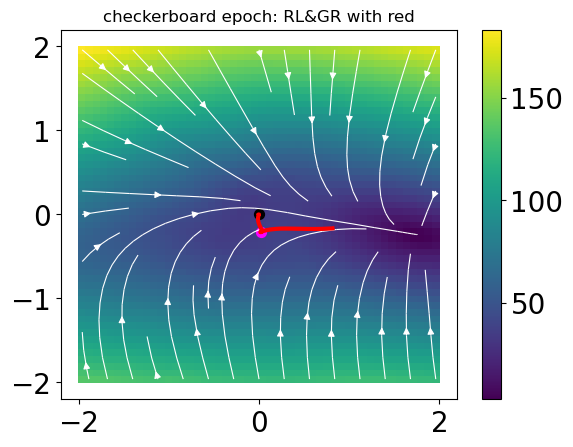

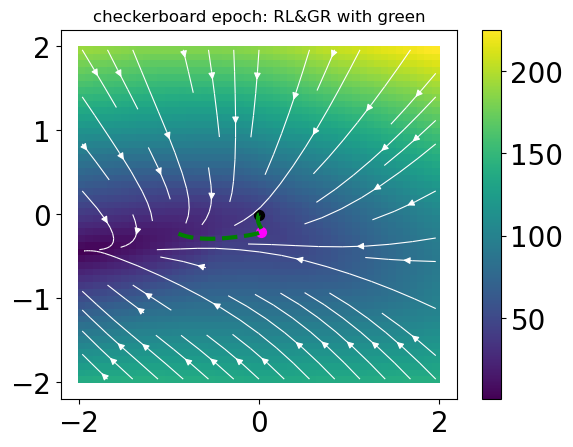

In [45]:

# checkerboard epoch
kap1C = kap[:,COn:, dim1]
kap3C = kap[:,COn:, dim2]
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
[ax, mappable] = ranktwo.plot_field(net_lo, m[:, dim1], m[:,dim2], -2, 2, -2, 2, input=torch.tensor([0.9,1, -1]))

mappable.set_cmap('viridis')
plt.colorbar(mappable)


plt.plot(kap[0,:,dim1], kap[0,:,dim2], c=colors[0], lw=3, ls=lineStyle[0])
plt.scatter(kap[0, TOn, dim1], kap[0, TOn, dim2], c= 'k',
    marker='.', s=200)  
plt.scatter(kap[0, COn, dim1], kap[0, COn, dim2], c= 'magenta',
    marker='.', s=200) 

plt.title('checkerboard epoch: RL&GR with red')        
# plt.savefig('TFT1R.pdf', bbox_inches='tight')
        
plt.show()






# checkerboard epoch

[ax, mappable] = ranktwo.plot_field(net_lo, m[:, dim1], m[:,dim2], -2, 2, -2, 2, input=torch.tensor([-0.9,1, -1]))

mappable.set_cmap('viridis')
plt.colorbar(mappable)

plt.plot(kap[3,:,dim1], kap[3,:,dim2], c=colors[3], lw=3, ls=lineStyle[3])
plt.scatter(kap[3, TOn, dim1], kap[3, TOn, dim2], c= 'k',
    marker='.', s=200)  
plt.scatter(kap[3, COn, dim1], kap[3, COn, dim2], c= 'magenta',
    marker='.', s=200) 


plt.title('checkerboard epoch: RL&GR with green')        
# plt.savefig('TFT1G.pdf', bbox_inches='tight')
        
plt.show()



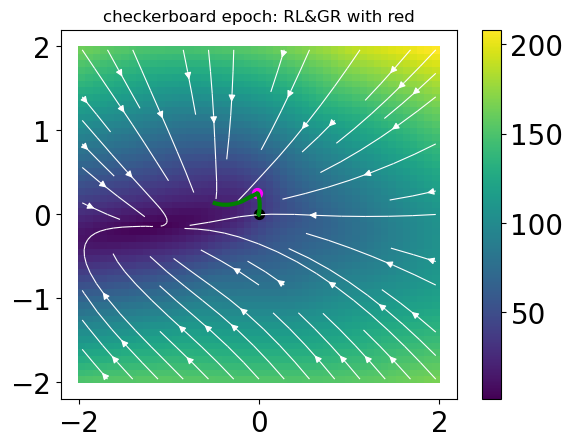

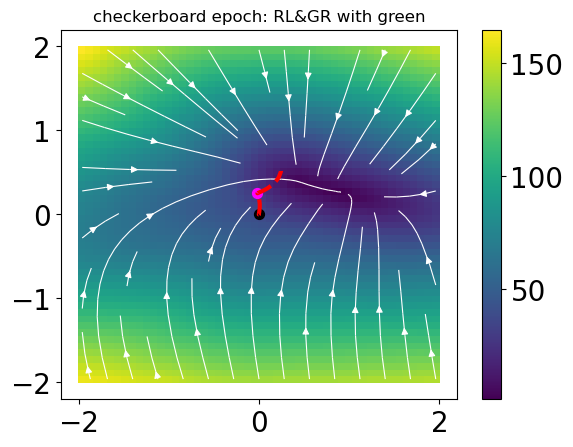

In [46]:

# checkerboard epoch
kap1C = kap[:,COn:, dim1]
kap3C = kap[:,COn:, dim2]
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
[ax, mappable] = ranktwo.plot_field(net_lo, m[:, dim1], m[:,dim2], -2, 2, -2, 2, input=torch.tensor([-0.9,-1, 1]))

mappable.set_cmap('viridis')
plt.colorbar(mappable)


plt.plot(kap[2,:,dim1], kap[2,:,dim2], c=colors[2], lw=3, ls=lineStyle[2])
plt.scatter(kap[2, TOn, dim1], kap[2, TOn, dim2], c= 'k',
    marker='.', s=200)  
plt.scatter(kap[2, COn, dim1], kap[2, COn, dim2], c= 'magenta',
    marker='.', s=200) 

plt.title('checkerboard epoch: RL&GR with red')        
# plt.savefig('TFT1R.pdf', bbox_inches='tight')
        
plt.show()






# checkerboard epoch

[ax, mappable] = ranktwo.plot_field(net_lo, m[:, dim1], m[:,dim2], -2, 2, -2, 2, input=torch.tensor([0.9,-1, 1]))

mappable.set_cmap('viridis')
plt.colorbar(mappable)

plt.plot(kap[1,:,dim1], kap[1,:,dim2], c=colors[1], lw=3, ls=lineStyle[1])
plt.scatter(kap[1, TOn, dim1], kap[1, TOn, dim2], c= 'k',
    marker='.', s=200)  
plt.scatter(kap[1, COn, dim1], kap[1, COn, dim2], c= 'magenta',
    marker='.', s=200) 


plt.title('checkerboard epoch: RL&GR with green')        
# plt.savefig('TFT1G.pdf', bbox_inches='tight')
        
plt.show()
